# Objetivo do Projeto

O principal objetivo neste notebook é <u>treinar e demonstrar o meu conhecimento sobre modelos supervisionados de classificação</u>. Por esse motivo, escolhi um conjunto de dados desbalanceados de usuários de contas bancárias de uma empresa fictícia (Top Bank) para prever a rotatividade dos clientes - <i>Churn Prediction</i>. Além da criação do modelo de previsão, criei um contexto e questionamentos que devem ser respondidos através da análise do conjunto de dados e do desempenho do modelo.

## Contexto:
Top Bank atua na Europa tendo como principal produto uma conta bancária. Este produto pode manter o salário do cliente e efetuar pagamentos. Essa conta não tem nenhum custo nos primeiros 12 meses, porém, após esse período, o cliente precisa recontratar o banco para os próximos 12 meses e refazer esse processo todos os anos. Recentemente, a equipe de análise notou que a taxa de churn está aumentando.
Como Cientista de Dados, você precisa criar um plano de ação para diminuir o número de clientes churn e mostrar o retorno financeiro da sua solução.
Além disso, você precisará fornecer um relatório relatando o desempenho de seu modelo e o impacto financeiro de sua solução.

Perguntas que o CEO e a equipe do Analytics gostariam de ver em seu relatório:

1. **Qual é a atual taxa de churn do Top Bank?**
2. **Qual é o desempenho do modelo na classificação de clientes como churns?**
3. **Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?**

# Importações (bibliotecas, dados e funções)

## Bibliotecas

In [1]:
import sys
sys.path.append('../..') #caminho relativo para pasta utils

In [72]:
#Descrição, Manipulação e Visualização de Dados
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt

# Modelagem Preditiva
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, recall_score

#Model Saving
import pickle

## Funções

In [3]:
def print_model_performance_logistic_reg(scores):
    mean_ACCURACY = scores['test_ACCURACY'].mean()
    std_ACCURACY = scores['test_ACCURACY'].std()

    mean_PRECISION = scores['test_PRECISION'].mean()
    std_PRECISION = scores['test_PRECISION'].std()
    
    mean_RECALL = scores['test_RECALL'].mean()
    std_RECALL = scores['test_RECALL'].std()
    
    mean_AUC = scores['test_AUC'].mean()
    std_AUC = scores['test_AUC'].std()

    print(f"Pontuação de validação (ACCURACY): {+mean_ACCURACY:.3f} ± {+std_ACCURACY:.3f}")
    print(f"Pontuação de validação (PRECISION): {+mean_PRECISION:.3f} ± {+std_PRECISION:.3f}")
    print(f"Pontuação de validação (RECALL): {+mean_RECALL:.3f} ± {+std_RECALL:.3f}")
    print(f"Pontuação de validação (AUC): {+mean_AUC:.3f} ± {+std_AUC:.3f}")
    
    return None

def print_model_performance_bayes_search(bayes_search_obj):
    mean_ACCURACY = bayes_search_obj.cv_results_['mean_test_ACCURACY'][bayes_search_obj.best_index_]
    std_ACCURACY = bayes_search_obj.cv_results_['std_test_ACCURACY'][bayes_search_obj.best_index_]
    
    mean_PRECISION = bayes_search_obj.cv_results_['mean_test_PRECISION'][bayes_search_obj.best_index_]
    std_PRECISION = bayes_search_obj.cv_results_['std_test_PRECISION'][bayes_search_obj.best_index_]

    mean_RECALL = bayes_search_obj.cv_results_['mean_test_RECALL'][bayes_search_obj.best_index_]
    std_RECALL = bayes_search_obj.cv_results_['std_test_RECALL'][bayes_search_obj.best_index_]
    
    mean_AUC = bayes_search_obj.cv_results_['mean_test_AUC'][bayes_search_obj.best_index_]
    std_AUC = bayes_search_obj.cv_results_['std_test_AUC'][bayes_search_obj.best_index_]
    
    mean_AUPRC = bayes_search_obj.cv_results_['mean_test_AUPRC'][bayes_search_obj.best_index_]
    std_AUPRC = bayes_search_obj.cv_results_['std_test_AUPRC'][bayes_search_obj.best_index_]
    
    print(f"Melhor pontuação de validação (ACCURACY): {+mean_ACCURACY:.3f} ± {+std_ACCURACY:.3f}")
    print(f"Melhor pontuação de validação (PRECISION): {+mean_PRECISION:.3f} ± {+std_PRECISION:.3f}")
    print(f"Melhor pontuação de validação (RECALL): {+mean_RECALL:.3f} ± {+std_RECALL:.3f}")
    print(f"Melhor pontuação de validação (AUC): {+mean_AUC:.3f} ± {+std_AUC:.3f}")
    print(f"Melhor pontuação de validação (AUPRC): {+mean_AUPRC:.3f} ± {+std_AUPRC:.3f}")
    
    return None

## Dados

In [4]:
df = pd.read_csv('../data/churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Descrição e Manipulação de Dados

## Significado dos Dados

- **RowNumber**: o número dos registros
- **CustomerID**: identificador único de clientes
- **Surname**: sobrenome do cliente
- **CreditScore**: pontuação de crédito do cliente para o mercado financeiro (quanto maior o score, é um bom pagador)
- **Geography**: o país do cliente
- **Gender**: o gênero do cliente
- **Age**: a idade do cliente
- **Tenure**: número de anos que o cliente está no banco
- **Balance**: o valor que o cliente tem em sua conta
- **NumOfProducts**: o número de produtos que o cliente possui (no caso, contas)
- **HasCrCard**: se o cliente tiver cartão de crédito
- **IsActiveMember**: se o cliente estiver ativo (nos últimos 12 meses)
- **EstimateSalary**: estimativa de salário anual dos clientes
- **Exited**: se o cliente for churn (*variável resposta*)

## Renomeando Variáveis

In [5]:
renamed_columns = ['numero_linha', 'id_cliente', 'sobrenome', 'score_credito', 'geografia', 'genero', 'idade', 'tempo_permanencia', 
                   'saldo', 'numero_de_contas', 'tem_cartao_credito', 'membro_ativo', 'salario_estimado', 'Churn']
df.columns = renamed_columns

## Dimensão dos Dados

In [1]:
df_dimensions = df.shape
print(f'A base de dados possui {df_dimensions[0]} registros de clientes com {df_dimensions[1]} variáveis.')

NameError: name 'df' is not defined

## Tipos de Dados

In [7]:
df.dtypes

numero_linha            int64
id_cliente              int64
sobrenome              object
score_credito           int64
geografia              object
genero                 object
idade                   int64
tempo_permanencia       int64
saldo                 float64
numero_de_contas        int64
tem_cartao_credito      int64
membro_ativo            int64
salario_estimado      float64
Churn                   int64
dtype: object

## Checagem de Existência de Dados Duplicados

In [8]:
df[df.duplicated(subset= ['id_cliente'])]

,numero_linha,id_cliente,sobrenome,score_credito,geografia,genero,idade,tempo_permanencia,saldo,numero_de_contas,tem_cartao_credito,membro_ativo,salario_estimado,Churn


- <u>Obs.</u>: A base de dados não possui dados duplicados.

## Manipulação de Conflitos Gerados por Valores Faltantes e Zerados

In [9]:
utils.print_missing_values_in_dataframe(df)

O dataframe não possui valores faltantes


In [10]:
utils.print_zero_values_in_dataframe(df)

'tempo_permanencia' possui 413 registros zerados (4.13%)
'saldo' possui 3617 registros zerados (36.17%)
'tem_cartao_credito' possui 2945 registros zerados (29.45%)
'membro_ativo' possui 4849 registros zerados (48.49%)
'Churn' possui 7963 registros zerados (79.63%)


### Nota:
De fato, as variáveis **tempo_permanencia, saldo, tem_cartao_credito, membro_ativo e Churn** podem assumir valores zerados.
    
<u>Obs.</u>: Uma análise de conformidade nas variáveis zeradas poderia ser realizada se houvessem variáveis associadas. Como não é o caso, vou assumir que o conjunto de dados é consistente.

## Criação de Variáveis

In [11]:
#Escala FICO: escala de qualidade do score de crédito usada nos EUA.
bins = [300, 580, 670, 740, 800, float('inf')]
labels = ['too bad', 'bad', 'good', 'very good', 'excellent']

df['escala_fico'] = pd.cut(df['score_credito'], bins=bins, labels=labels, right=False)

## Alterando os tipos das variáveis

In [12]:
# Transformando algumas variáveis de tipo "integer" em tipo "category"
integer_variables_to_category_type = ['tem_cartao_credito', 'membro_ativo', 'Churn']
df[integer_variables_to_category_type] = df[integer_variables_to_category_type].astype('category')

# Transformando o restante das variáveis de tipo "object" para tipo "category"
object_columns = df.select_dtypes(include=['object']).columns
df[object_columns] = df[object_columns].astype('category')

In [13]:
df.dtypes

numero_linha             int64
id_cliente               int64
sobrenome             category
score_credito            int64
geografia             category
genero                category
idade                    int64
tempo_permanencia        int64
saldo                  float64
numero_de_contas         int64
tem_cartao_credito    category
membro_ativo          category
salario_estimado       float64
Churn                 category
escala_fico           category
dtype: object

## Nota:
Como não existe variável temporal, identificando o momento da extração dos dados, nasce alguns questionamentos:

	- Qual ponto no tempo a extração de dados foi feita? Qual é a relevância desse período?
    
	- Se os dados foi extraído como o resumo de 1 ano, o valor de saldo representa o valor presente na conta(s) no momento da extração, ou representa o somátorio de saldo presente na(s) conta(s) durante 1 ano, ou o valor máximo do saldo presente nesse período etc.
    
	- A variável Churn significa que o cliente de fato saiu da empresa ou possui a vontade de sair. Pois se o cliente de fato saiu da empresa, existe clientes que saíram do banco, mas que ainda possuiam saldo em suas contas.
    
	- O que seria de fato 'membro_ativo', clientes que fizeram transações em todos os meses do ano, ou pelo menos uma vez durante o período de extração?

<u>Obs.</u>: Pra esse projeto, irei modelar sem a resposta destas questões, embora, ter o contexto melhora o entendimento do problema e possivelmente melhore os resultados na modelagem dos dados.

### Plano para o Desenvolvimento das Questões de Negócio
Com o conhecimento prévio da base de dados, posso definir uma plano para o desenvolvimento da solução do problema de negócio:  

1. **Qual é a atual taxa de Churn do Top Bank?**
    - <b>S</b>: <u>Análise Univariada da variável de rotatividade (<b>Churn</b>)</u>: plotar gráfico de barras de churns e não-churns e printar porcentagem da relação das classes;


2. **Qual é o desempenho do modelo na classificação de clientes como churns?**
    - <b>S</b>: Criar modelo de classificação com as variáveis mais relevantes;
      
      
3. **Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?**
    - <b>S</b>: Com o modelo criado, é possível estimar o retorno esperado, criando casos de deduções sobre os salários estimados de cada cliente;

In [14]:
list_unselected_vars = ['id_cliente', 'sobrenome', 'numero_linha']

unselected_vars_df = df[list_unselected_vars]
df.drop(columns= list_unselected_vars, inplace= True)

# Análise Exploratória de Dados

## Análise Univariada

### Variáveis Quantitativas

- **Variáveis qualitativas nominais**: genero, geografia, tem_cartao_credito e membro_ativo;
- **Variáveis qualitativas ordinais**: escala_fico;

In [15]:
target_var_df = df[['Churn']]

qualitative_vars_df = df.select_dtypes(include= ['category'])
qualitative_vars_df.drop(columns= ['Churn'], inplace= True)

#### Variável Resposta

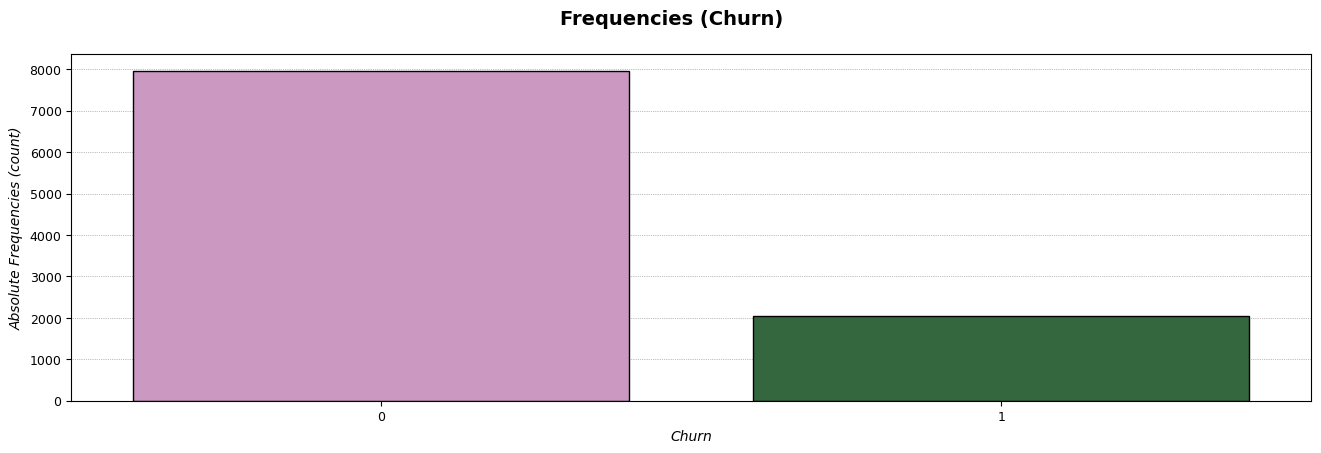

In [16]:
utils.plot_nominal_variables_distributions(target_var_df)

In [17]:
percentage_no_churn = target_var_df.value_counts()[0] / target_var_df.shape[0] * 100
percentage_yes_churn = target_var_df.value_counts()[1] / df.shape[0] * 100
print(f'Clientes que irão dar Churn correspondem a {percentage_yes_churn:.2f}%  da base de dados e clientes que não irão dar Churn correspondem a {percentage_no_churn:.2f}% da base de dados.')

Clientes que irão dar Churn correspondem a 20.37%  da base de dados e clientes que não irão dar Churn correspondem a 79.63% da base de dados.


- É evidente que a variável resposta possui classes desbalanceadas.

#### Variáveis Nominais

In [18]:
list_nominal_vars = ['genero', 'geografia', 'tem_cartao_credito', 'membro_ativo']

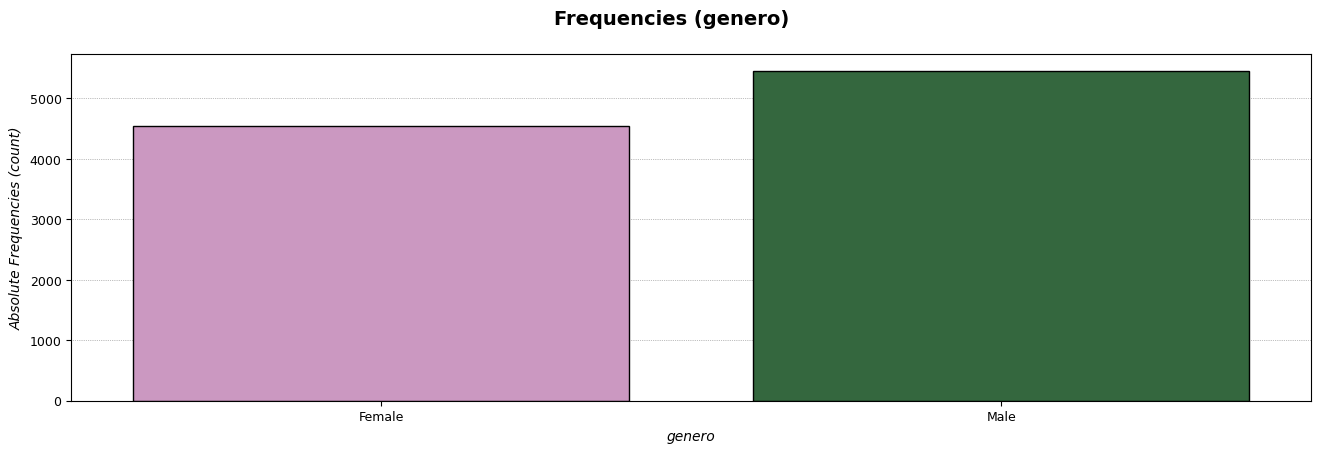

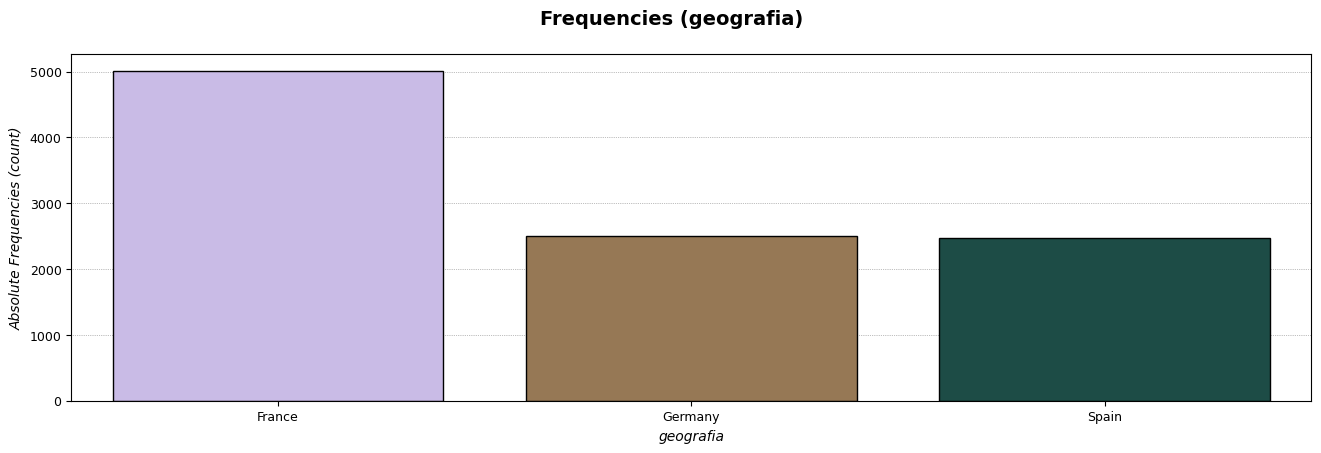

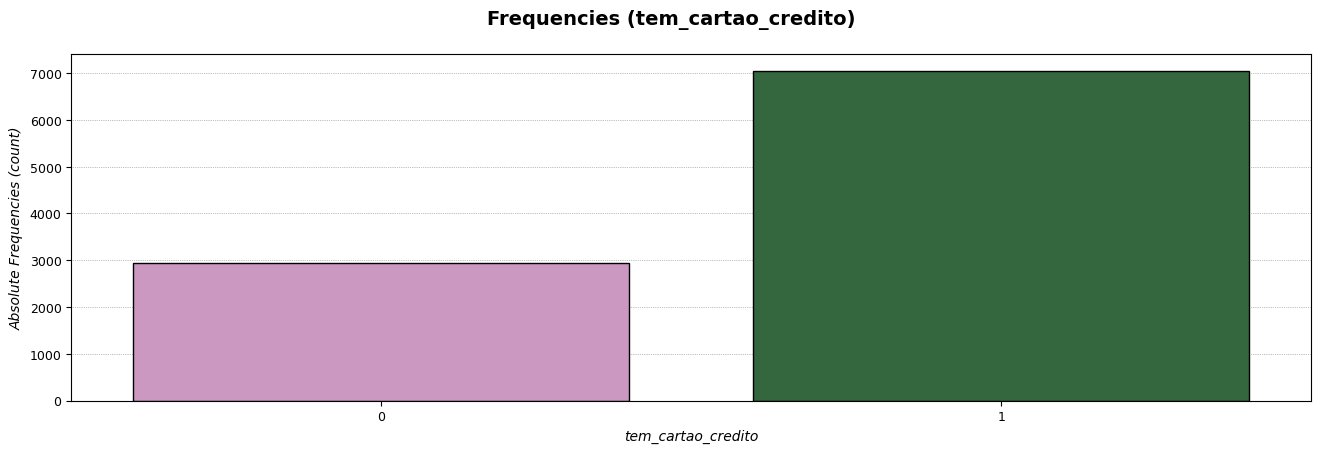

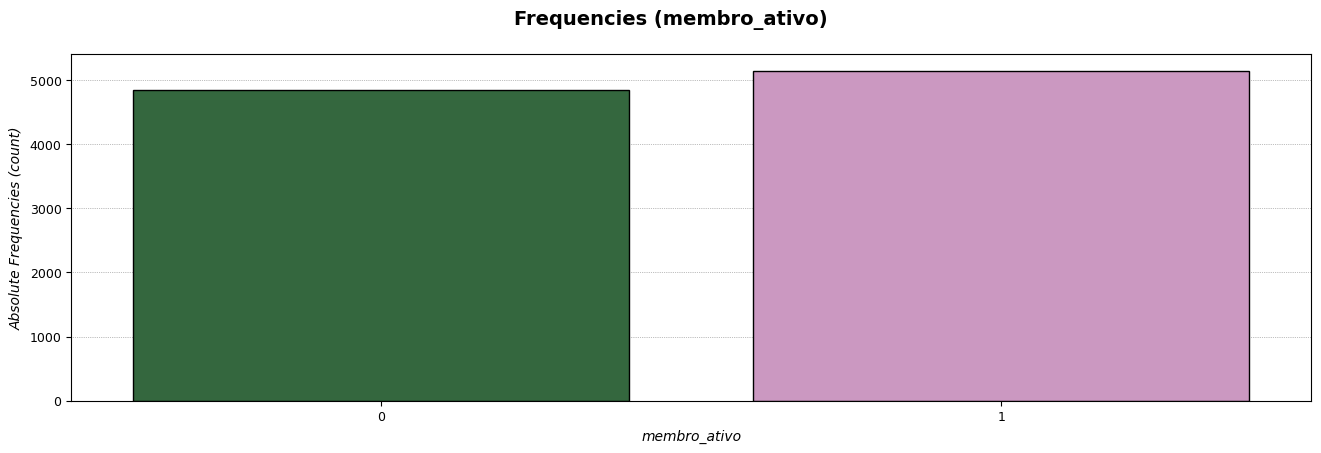

In [19]:
utils.plot_nominal_variables_distributions(qualitative_vars_df[list_nominal_vars])

#### Variáveis Ordinais

In [20]:
dict_ordinal_vars = {'escala_fico': ['too bad', 'bad', 'good', 'very good', 'excellent']}

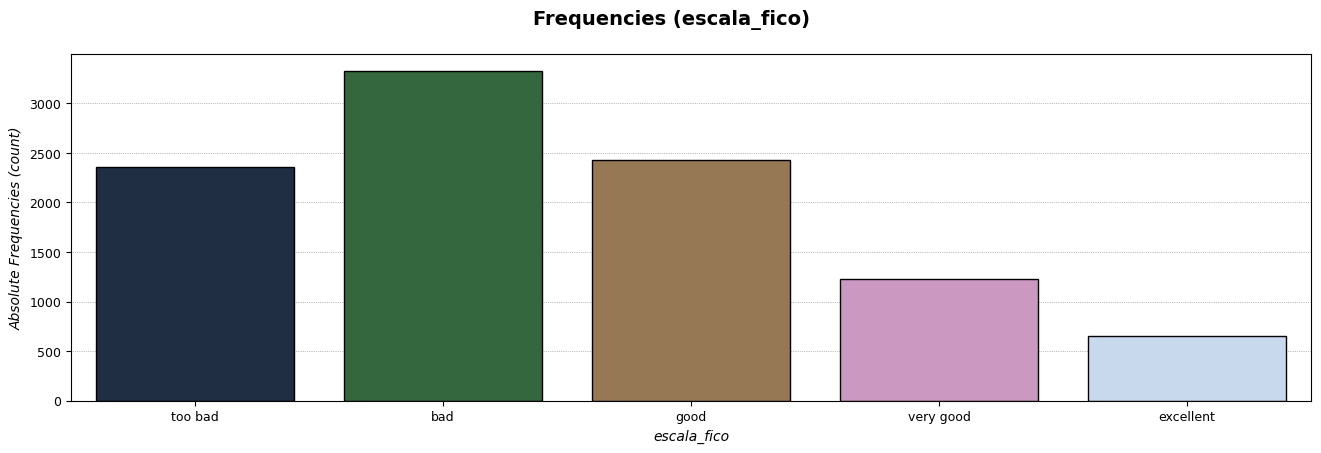

In [21]:
utils.plot_ordinal_variables_distributions(qualitative_vars_df, dict_ordinal_vars)

#### Nota:
Através dos gráficos das variáveis qualitativas, podemos perceber algumas particularidades que chamam atenção:

- **Geografia**: Metade dos clientes são da França, enquanto a outra metade se divide igualmente (1/4) entre Alemanha e Espanha;
- **Tem Cartão de Crédito**: 70% dos clientes possuem cartão de crédito;

### Variáveis Quantitativas

- **Variáveis quantitativas contínuas**: score_credito, idade, saldo, salário estimado;
- **Variáveis quantitativas discretas**: tempo_permanencia, numero_de_contas;

In [22]:
quantitative_vars_df = df.select_dtypes(include= ['int64', 'float64'])

#### Variáveis Contínuas

In [23]:
list_continuous_vars = ['score_credito', 'idade', 'saldo', 'salario_estimado']

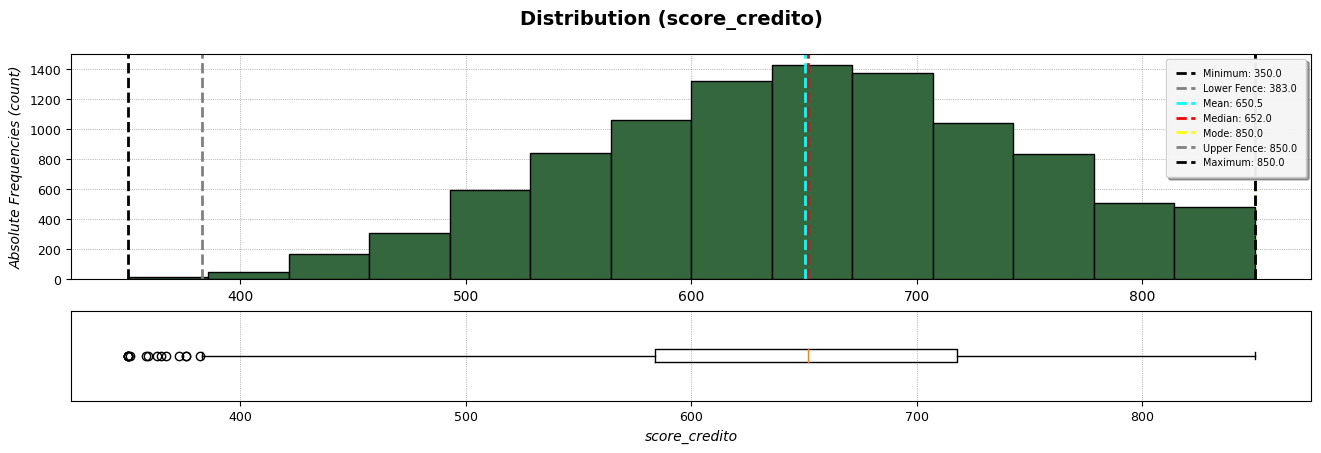

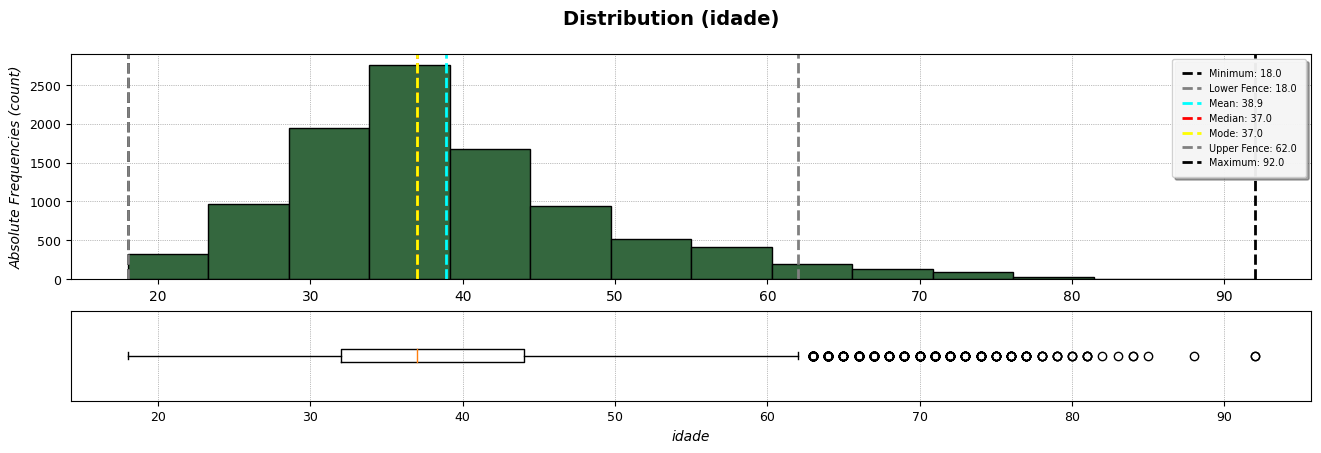

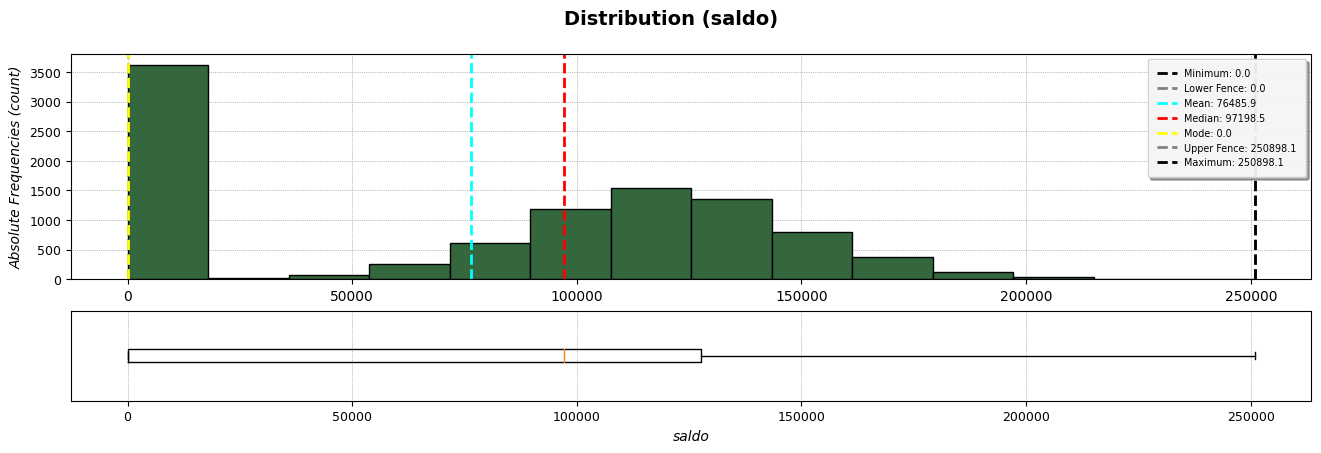

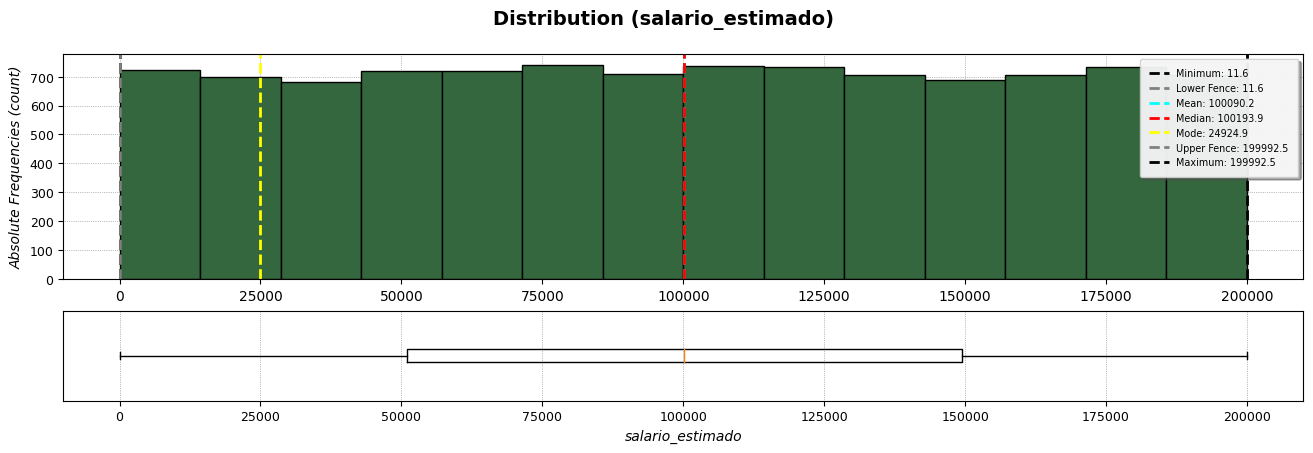

In [24]:
utils.plot_continuous_variables_distributions(quantitative_vars_df[list_continuous_vars])

In [25]:
utils.descriptive_statistics_continuous_variables(quantitative_vars_df[list_continuous_vars])

,Valores Únicos,Desv. Padrão,Variância,Assimetria,Curtose,Normalidade (p-value)
score_credito,460,96.653,9.341860e+03,-0.072,-0.426,9.716147e-04
idade,70,10.488,1.099940e+02,1.011,1.395,3.492314e-89
saldo,6382,62397.405,3.893436e+09,-0.141,-1.489,0.000000e+00
salario_estimado,9999,57510.493,3.307457e+09,0.002,-1.182,7.781996e-27


#### Variáveis Discretas

In [26]:
list_discrete_vars = ['tempo_permanencia', 'numero_de_contas']

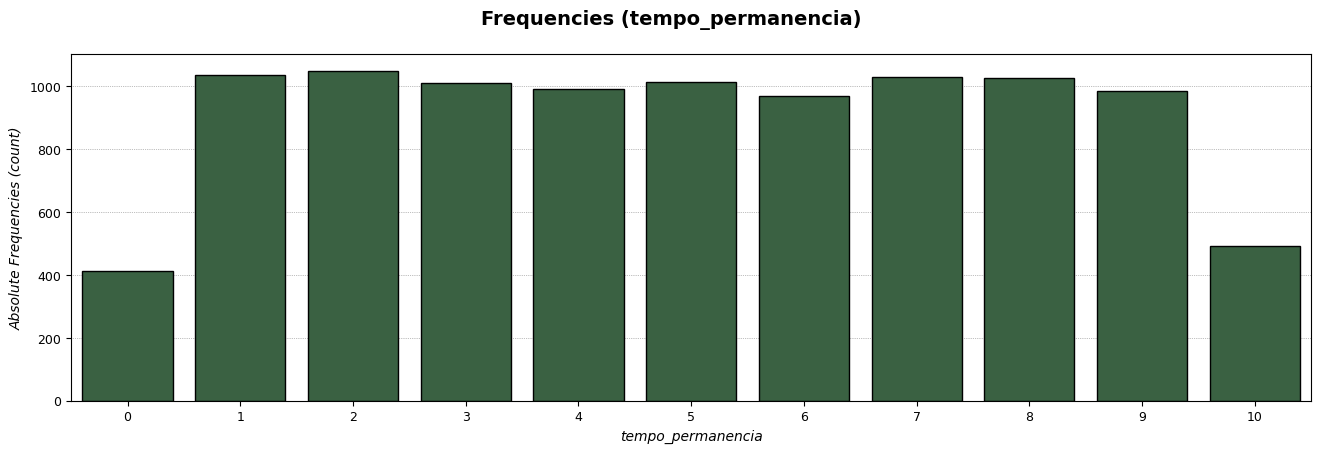

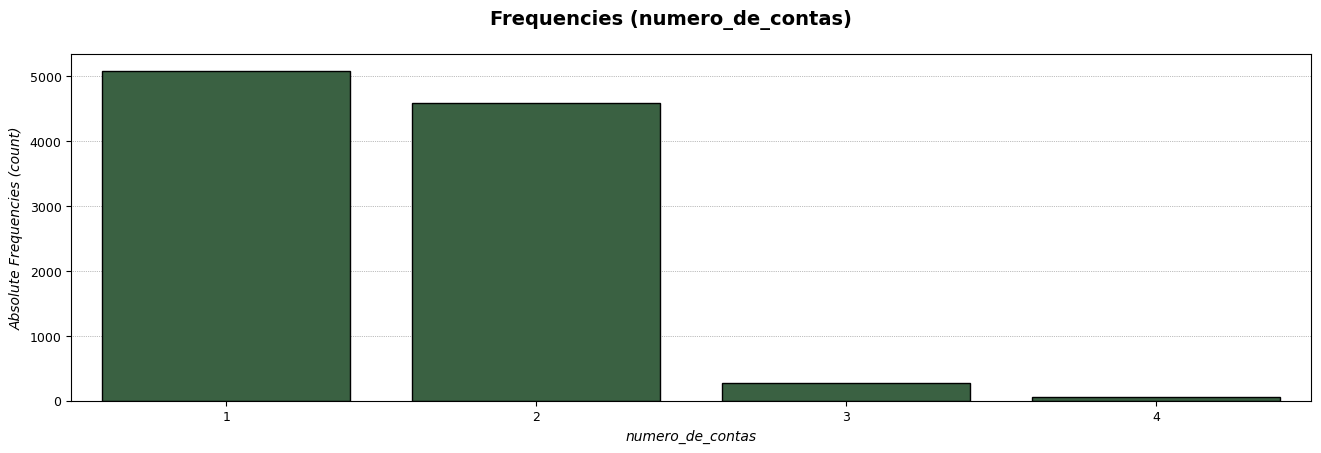

In [27]:
utils.plot_discrete_variables_distributions(quantitative_vars_df[list_discrete_vars])

#### Nota:
Através dos gráficos das variáveis quantitativas, podemos perceber algumas particularidades em cada variável:

- **Score de Crédito**:
    1. Presença de outliers significativos abaixo de 400 pontos, o que indica a existência de um pequeno grupo de clientes com scores de crédito excepcionalmente baixos;
    2. A moda é de 850 pontos, o valor mais alto possível, o que significa que há um grupo notável de clientes com excelente crédito;
    
    
- **Idade**:
    1. A maioria dos clientes está na faixa etária entre 30 e 50 anos, com uma distribuição simétrica em torno dos 37 anos;
    2. Existe uma presença de clientes mais idosos, e alguns aparecem como outliers, com idades superiores a 62 anos;


- **Saldo**:
    1. A distribuição do saldo das contas é bastante assimétrica, com a maioria dos usuários possuindo saldos baixos ou próximos de zero.
    2. Porém, há uma pequena porcentagem de clientes com saldos muito altos, o que puxa a média para cima e gera uma grande discrepância entre a média e a mediana, sugerindo que enquanto a maioria possui saldos modestos, e alguns poucos possuem valores consideravelmente altos.


- **Salário Estimado**:
    1. A distribuição é praticamente uniforme, sugere que o banco atende a uma ampla gama de clientes com salários variados.
    2.  O valor mínimo do salário estimado é extremamente baixo (11,6);
    
    
- **Tempo Permanência**:
    1. Para cada tempo de permanência, existem em torno de 1000 cliente, trazendo uniformidade a variável. 
    2. O que chama atenção é o 1º e 10º ano, sugerindo talvez, uma problema de aquisição de clientes ou rotatividade a partir do 9º ano.
    
    
- **Número de Contas**:
    1. Mais da metade dos clientes possuem apenas 1 conta, e um pouco menos da metade possuem duas contas. Menos de 5% dos clientes possuem entre 3 a 4 contas.

## Análise Bivariada (Variáveis Independentes x Variável Alvo)

### Variáveis Nominais x Variável Alvo

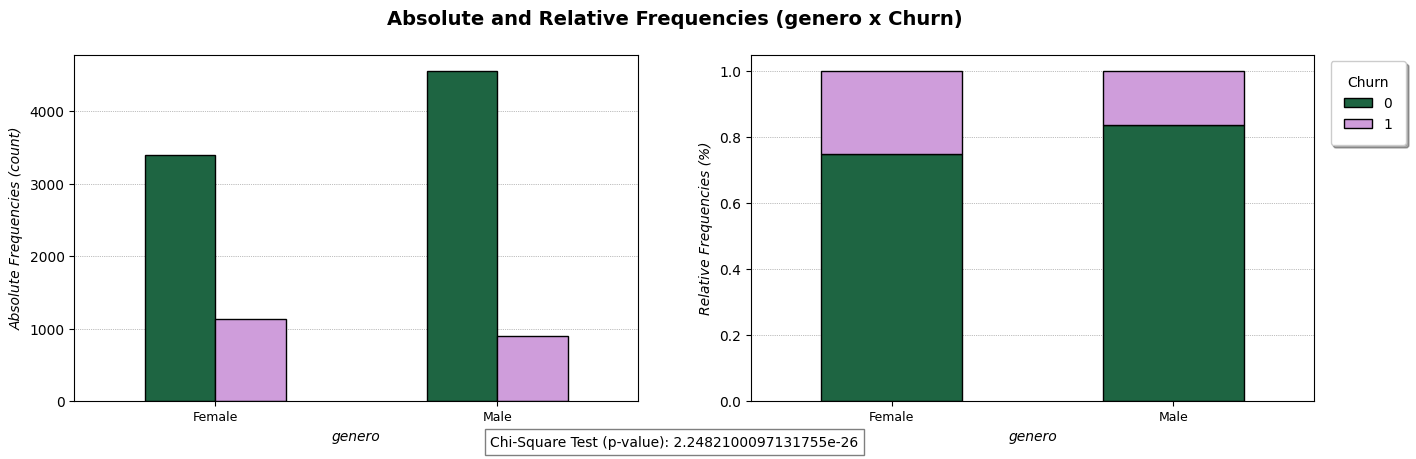

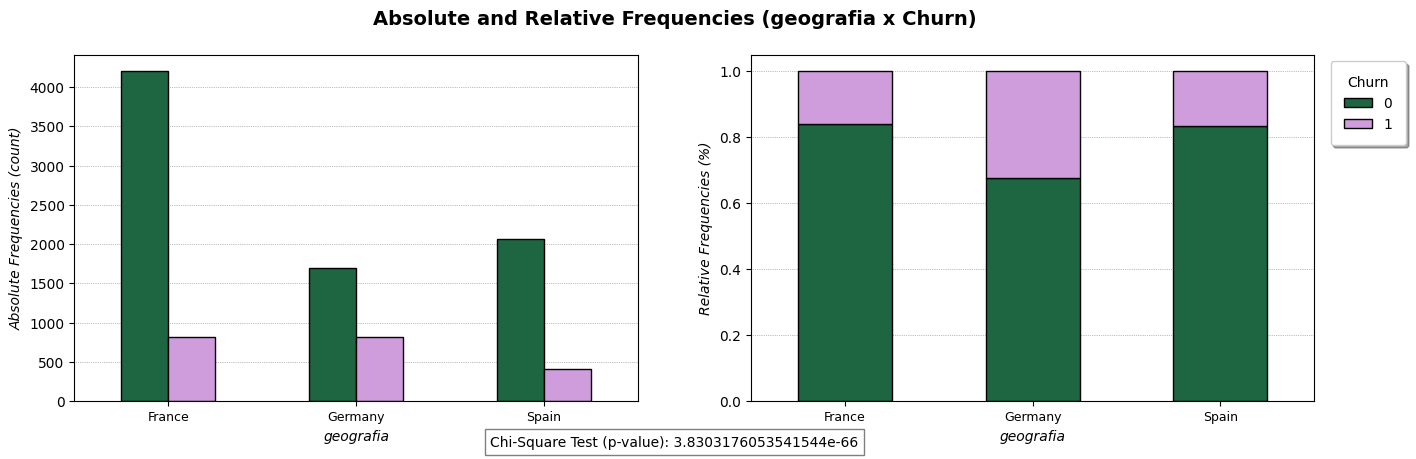

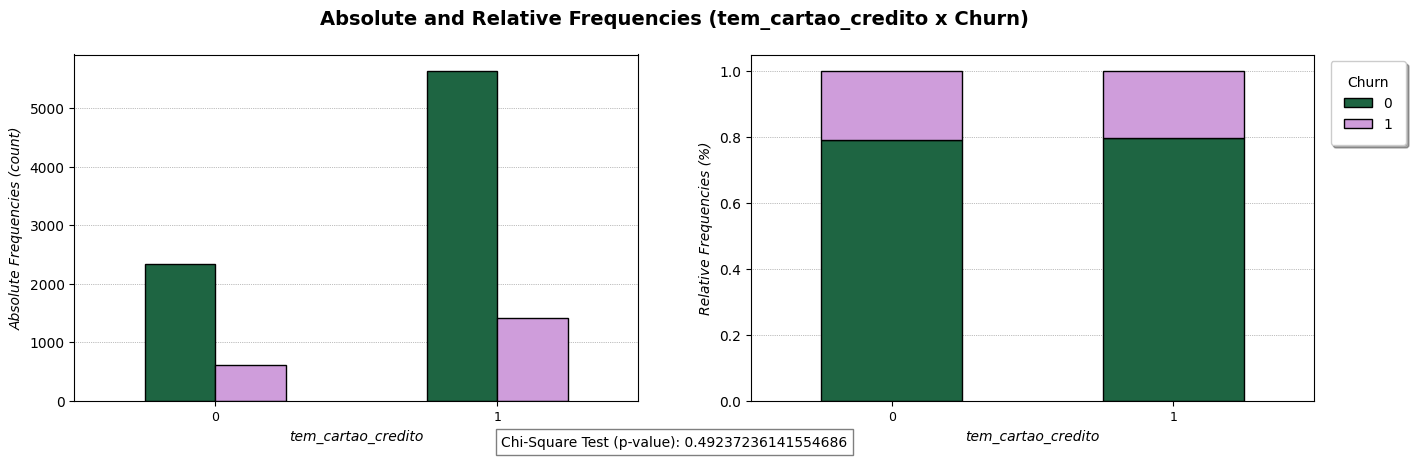

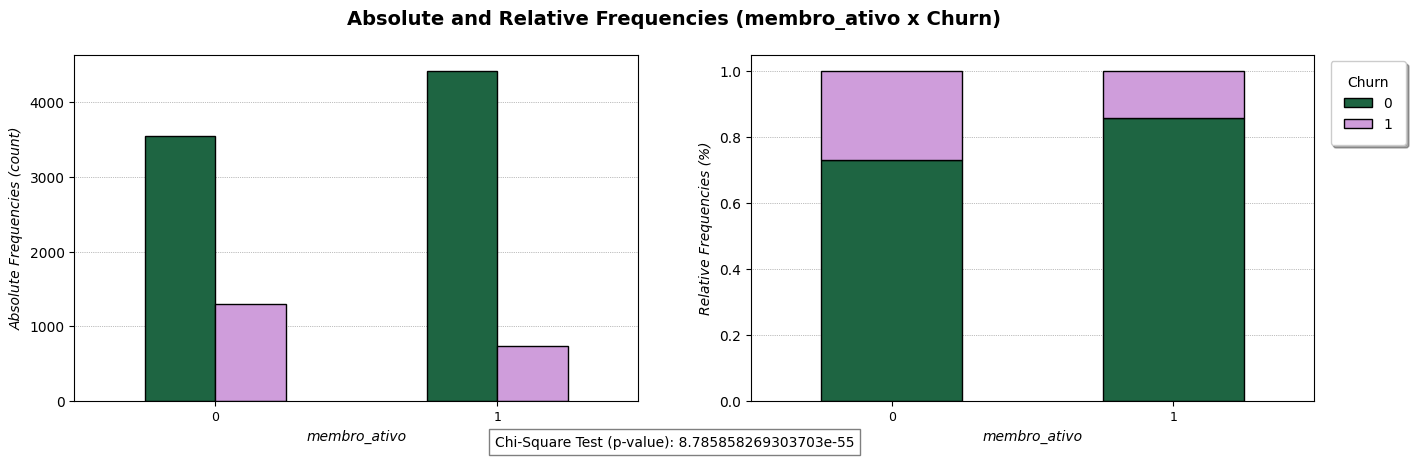

In [28]:
utils.plot_bivariate_analysis_qualitative_target_and_nominal_independent_vars(target_var_df, qualitative_vars_df[list_nominal_vars])

**Chi-Square Test (*h0*)**: As frequências observadas são iguais às esperadas.

### Variáveis Ordinais x Variável Alvo

In [29]:
list_ordinal_vars = list(dict_ordinal_vars.keys())

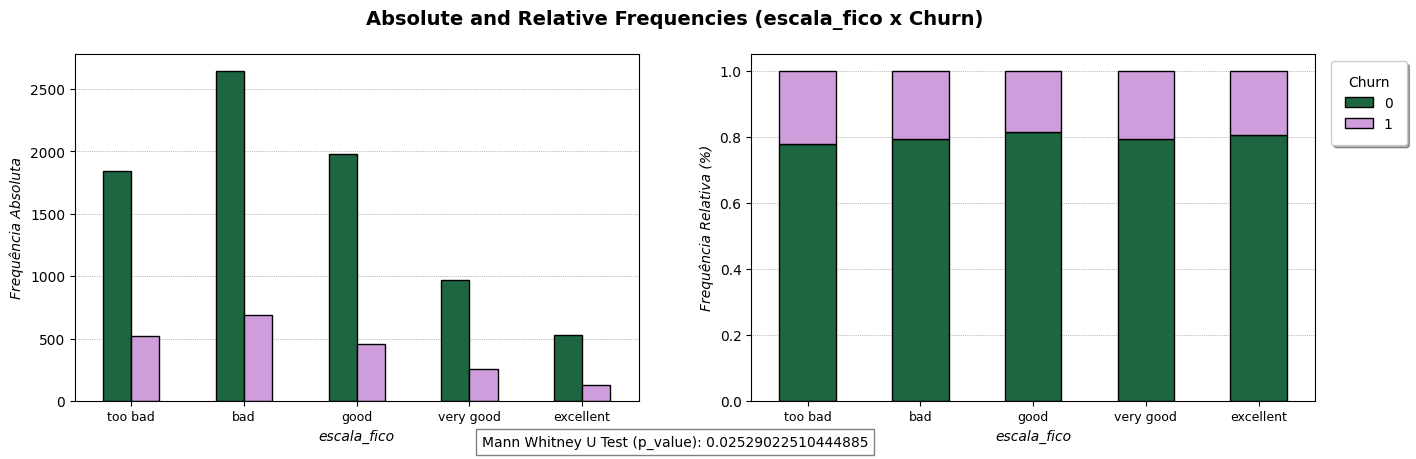

In [30]:
utils.plot_bivariate_analysis_qualitative_target_and_ordinal_independent_vars(target_var_df, qualitative_vars_df[list_ordinal_vars], dict_ordinal_vars)

**Mann-Whitney U (*h0*)**: As distribuições das duas populações que estão sendo comparadas são idênticas.

### Variáveis Discretas x Variável Alvo

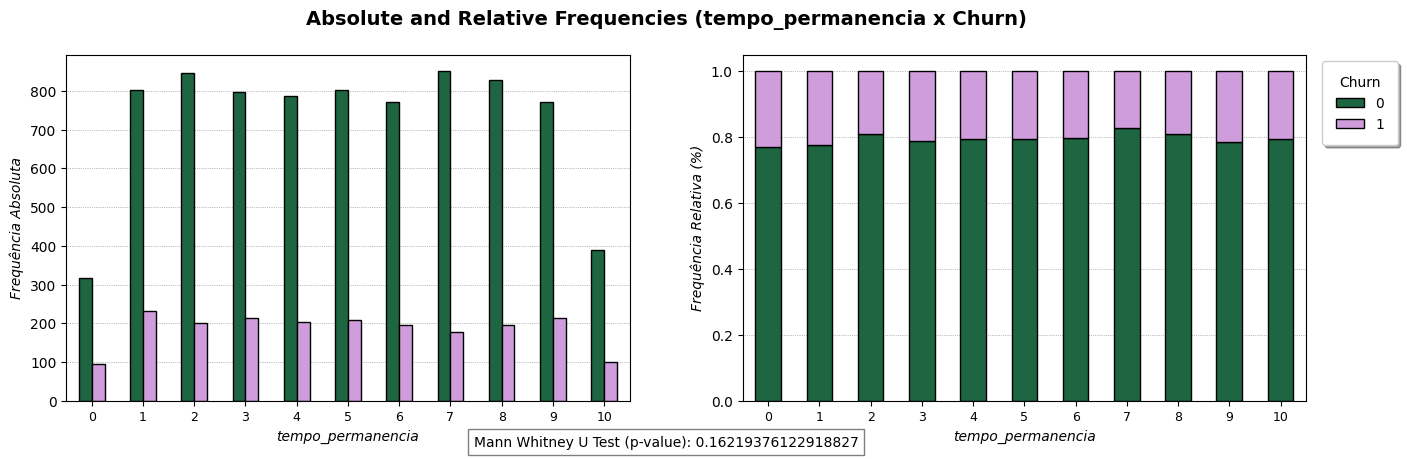

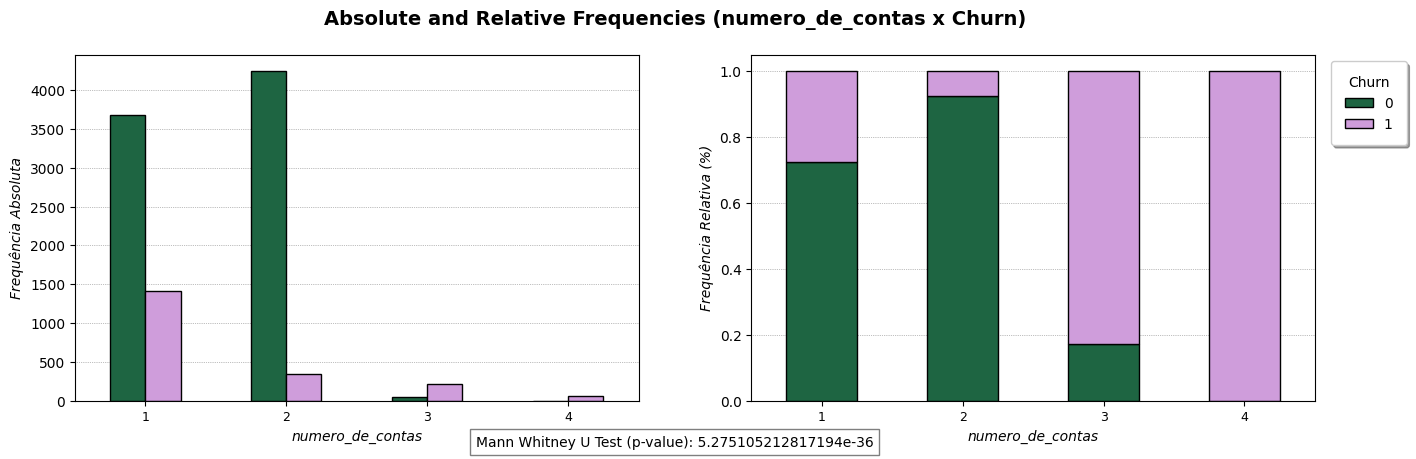

In [31]:
utils.plot_bivariate_analysis_qualitative_target_and_discrete_independent_vars(target_var_df, quantitative_vars_df[list_discrete_vars])

**Mann-Whitney U (*h0*)**: As distribuições das duas populações que estão sendo comparadas são idênticas.

### Variáveis Contínuas x Variável Alvo

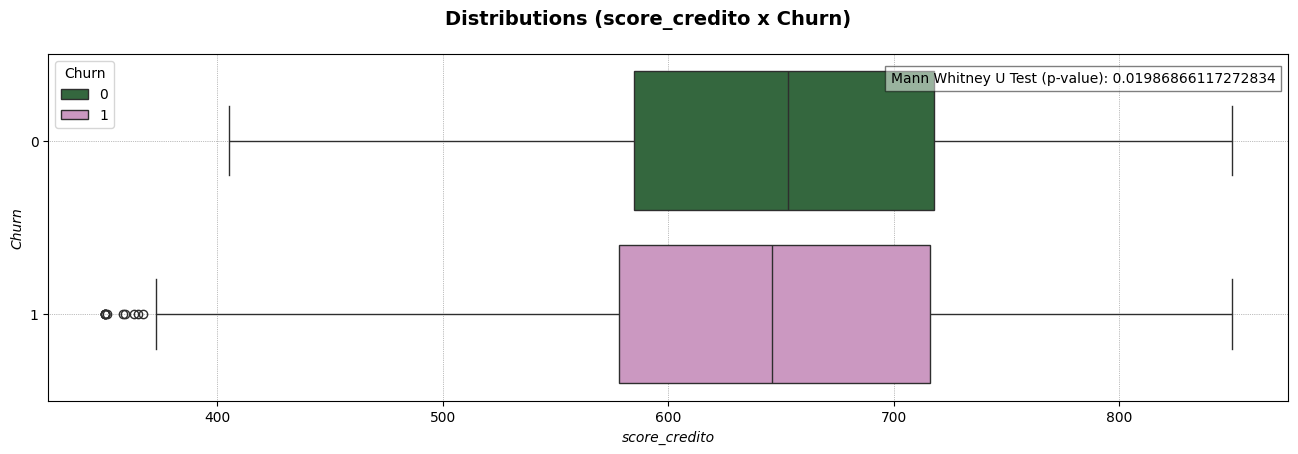

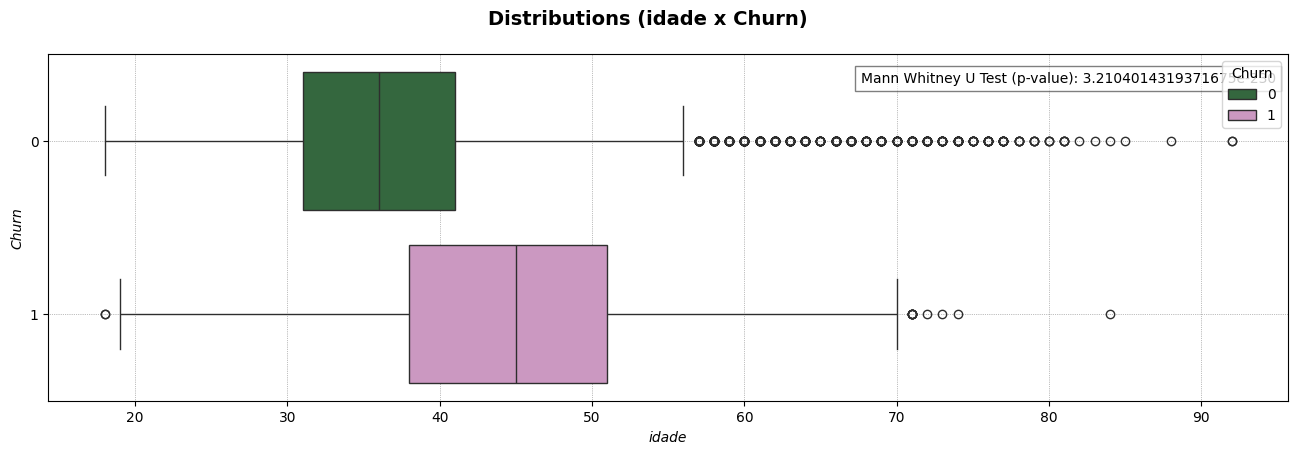

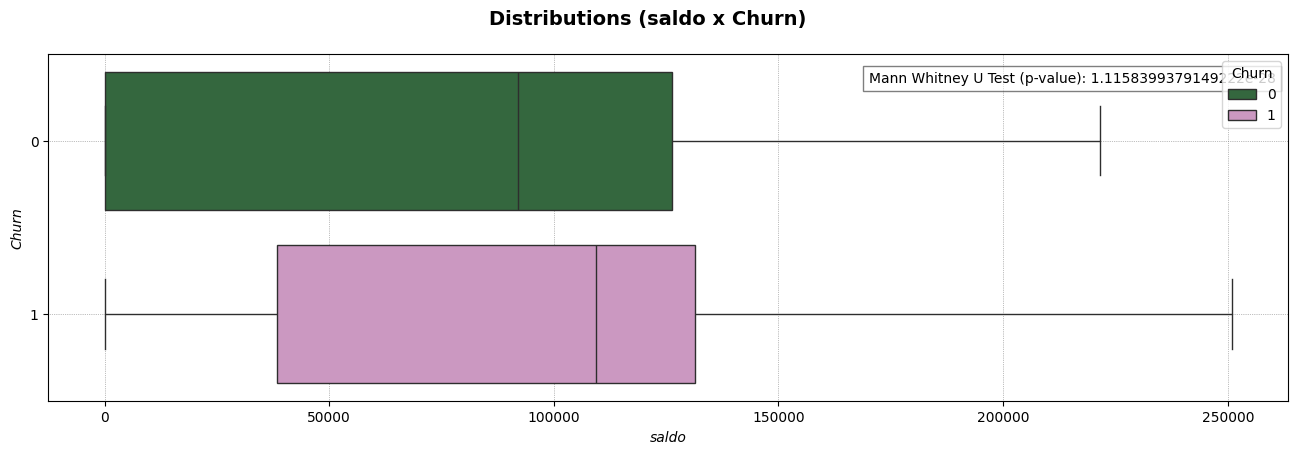

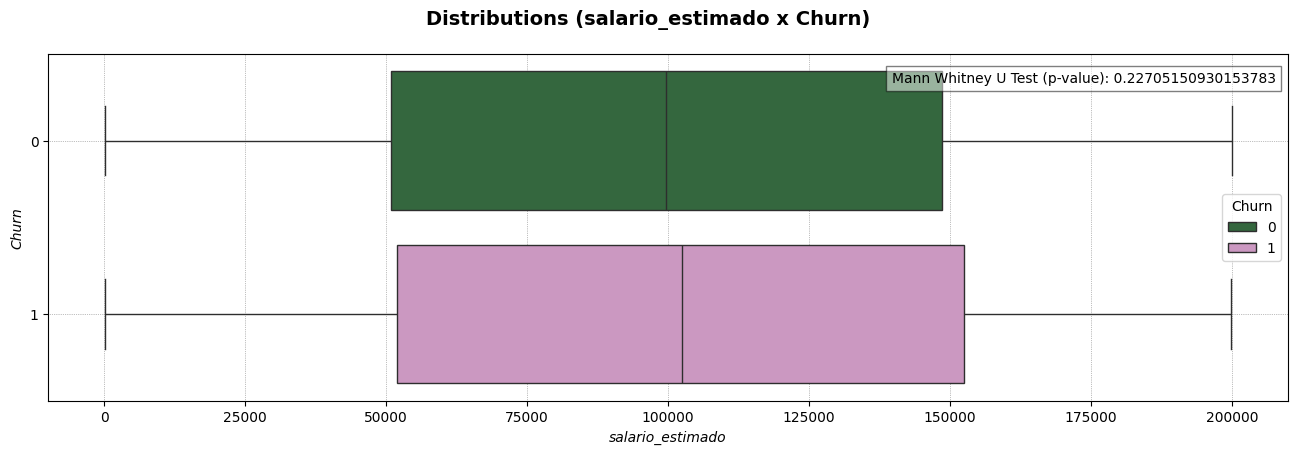

In [32]:
utils.plot_bivariate_analysis_qualitative_target_and_continuous_independent_vars(target_var_df, quantitative_vars_df[list_continuous_vars])

**Mann-Whitney U (*h0*)**: As distribuições das duas populações que estão sendo comparadas são idênticas.

### Nota:

Na análise bivariada, apenas as variáveis **tem_cartao_credito**, **tempo_permanencia** e **salario_estimado** não apresentam variabilidade suficiente quando comparadas entre os clientes positivos e negativos para churn, pois apresentam p-valores > 0.05 em seus testes estatísticos de comparação.

## Análise Multivariada de Dados

### Variáveis Qualitativas (Chi-Square, Mann-Whitney U, ou Kruskal-Wallis Testes)

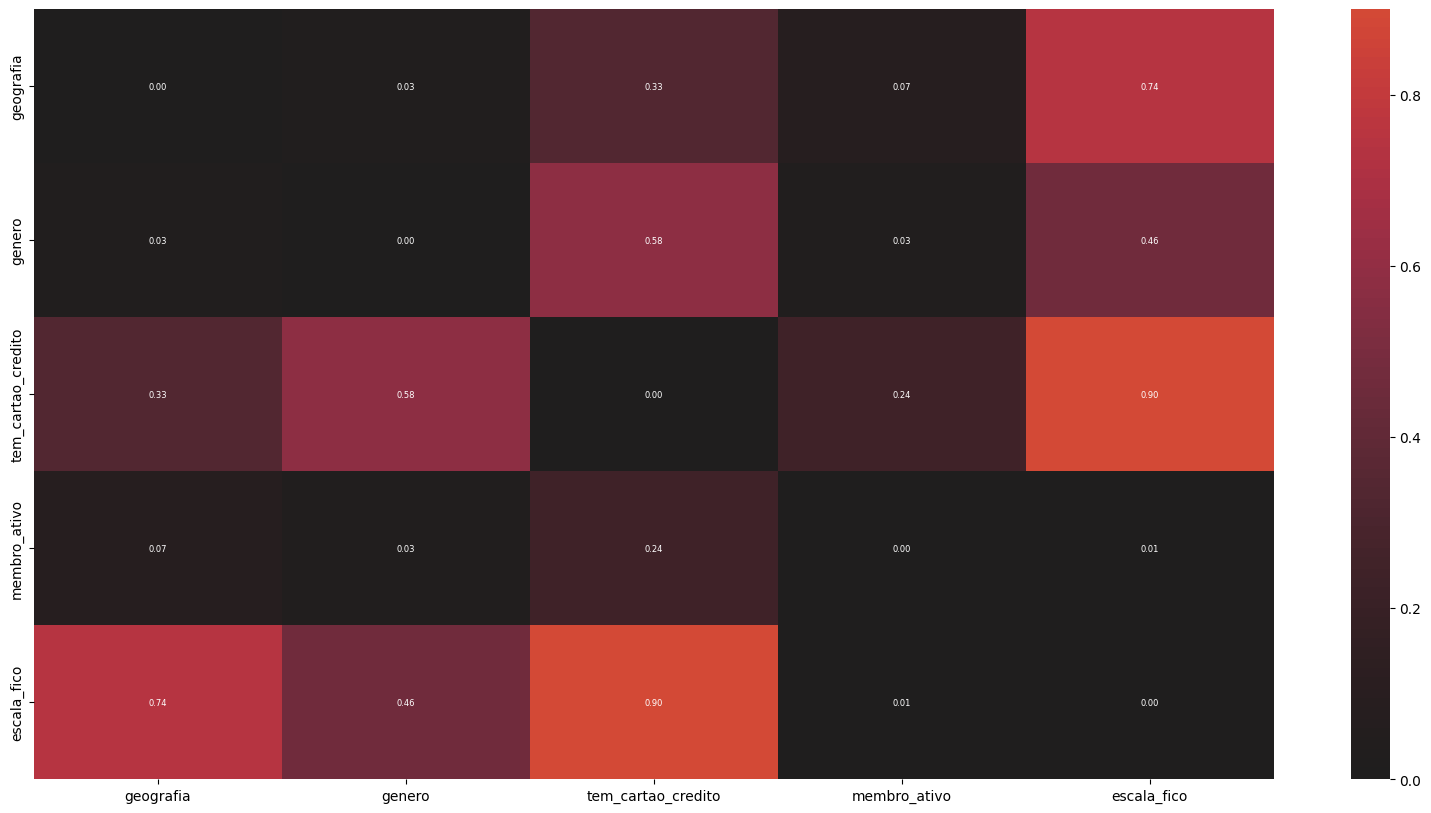

In [33]:
utils.plot_multivariate_heatmap_qualitative_vars(qualitative_vars_df, dict_ordinal_vars)

**Chi-Square Test (*h0*)**: As frequências observadas são iguais às esperadas.

**Mann-Whitney U (*h0*)**: As distribuições das duas populações que estão sendo comparadas são idênticas.

**Kruskall-Willis (*h0*)**: As distribuições das populações são iguais.

### Variáveis Qualitativas x Quantitativas (T-Test, ANOVA, Mann-Whitney U, ou Kruskal-Wallis Testes)

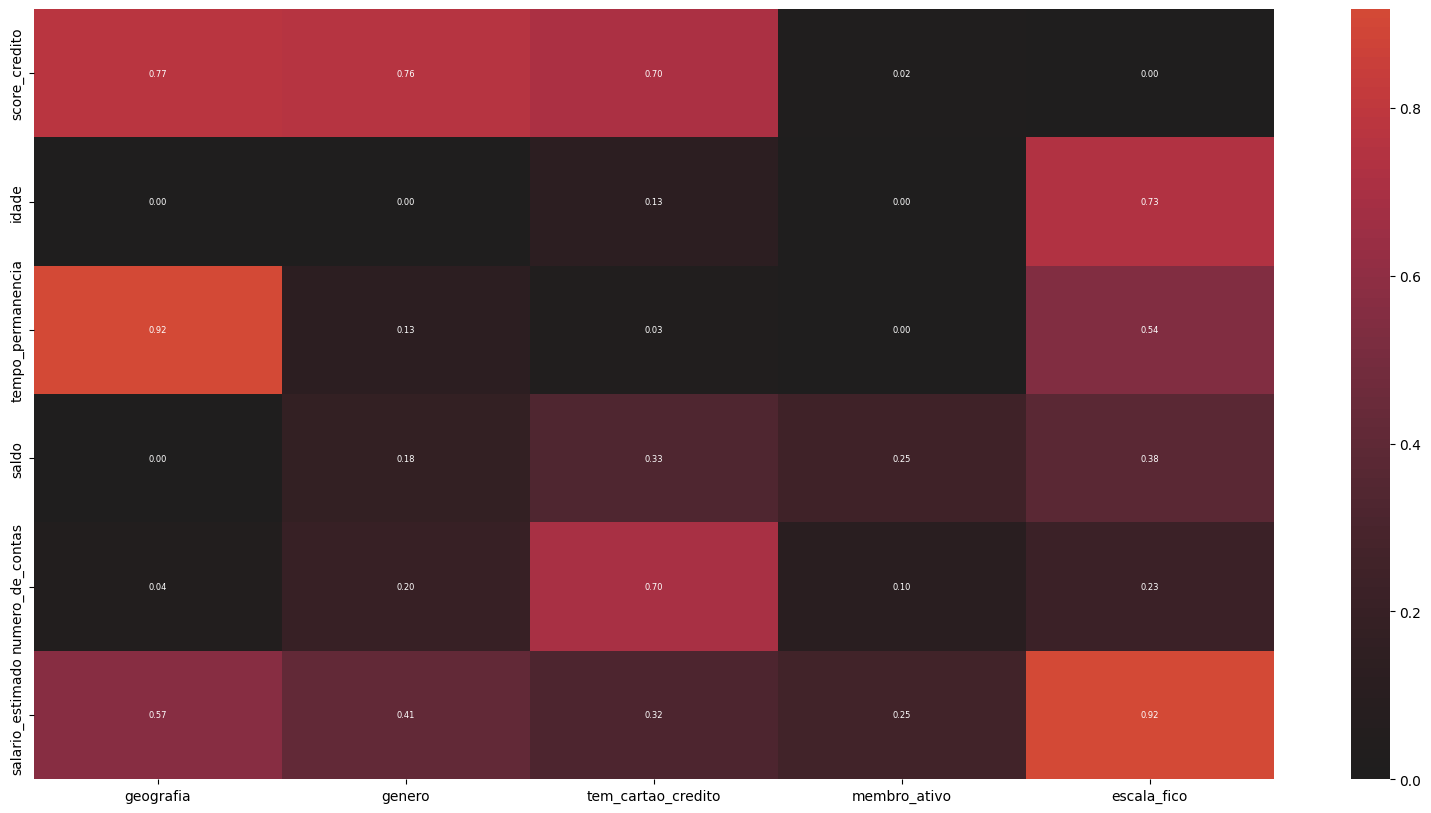

In [34]:
utils.plot_multivariate_heatmap_quantitative_qualitative_vars(quantitative_vars_df, qualitative_vars_df)

**T-Test (*h0*)**: As médias das duas populações são iguais.

**ANOVA (*h0*)**: As médias de todas as populações são iguais.

**Mann-Whitney U (*h0*)**: As distribuições das duas populações que estão sendo comparadas são idênticas.

**Kruskall-Willis (*h0*)**: As distribuições das populações são iguais.

### Variáveis Quantitativas (Correlação de Spearman)

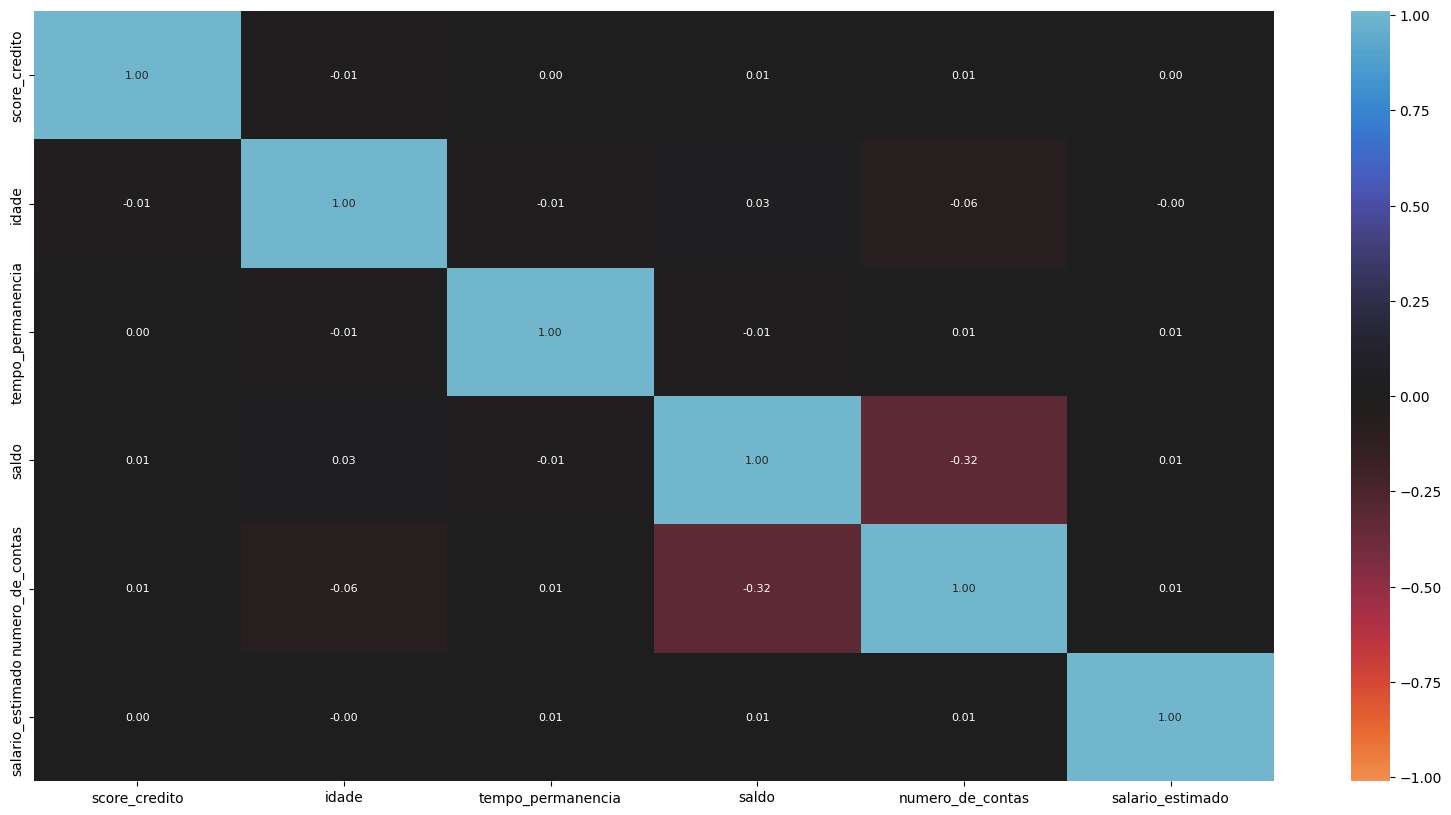

In [35]:
utils.plot_multivariate_heatmap_quantitative_vars(quantitative_vars_df)

### Note:

Das variáveis identificadas na análise bivariada como sem variabilidade suficiente quando comparadas com os grupos da variável alvo, todas, não apresentaram correlações e ou p-valores significativos quando comparadas com grupos de outras variáveis. Logo, serão desconsideradas para a modelagem do fenômeno. 

# Modelagem Preditiva

## Divisão dos Dados em Conjuntos de Treino e Teste

In [36]:
X = df.drop(columns= ['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state= 33)

In [37]:
X_train.reset_index(drop= True, inplace= True)
y_train.reset_index(drop= True, inplace= True)
X_test.reset_index(drop= True, inplace= True)
y_test.reset_index(drop= True, inplace= True)

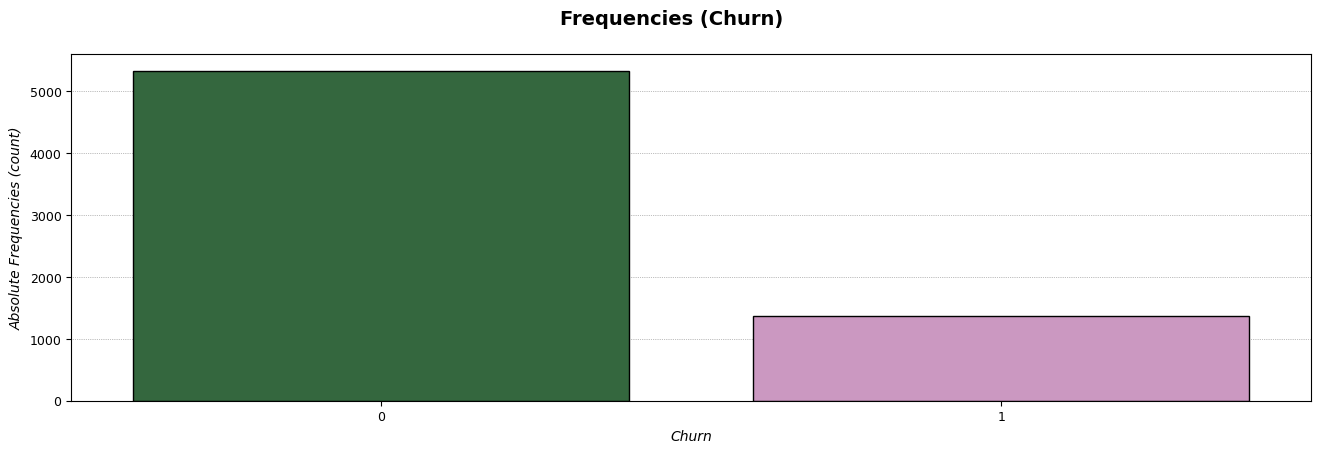

In [49]:
y_train_df = pd.DataFrame(y_train).sort_values('Churn', ascending= True)
utils.plot_nominal_variables_distributions(y_train_df)

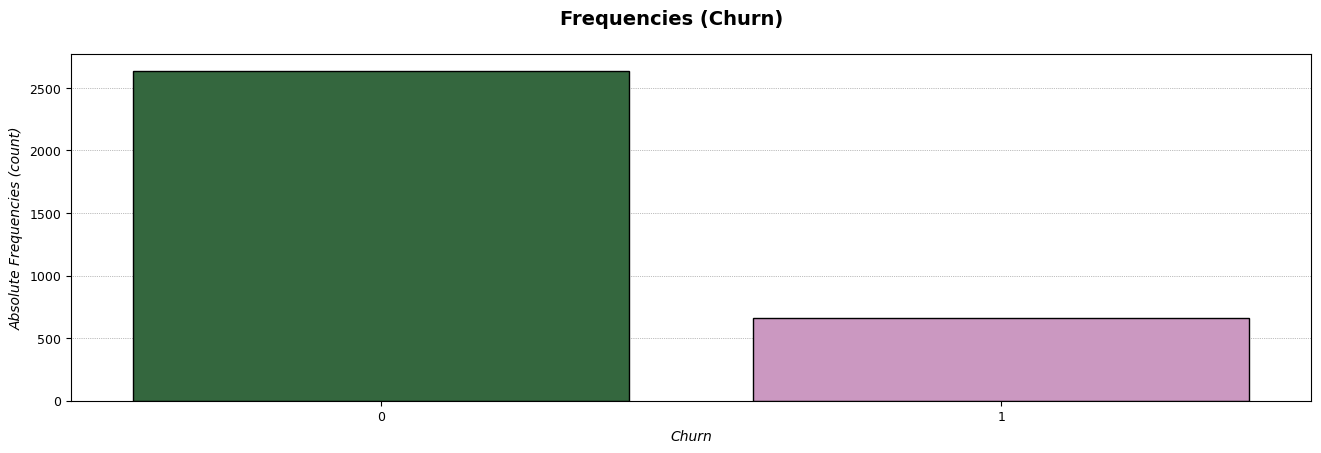

In [39]:
y_test_df = pd.DataFrame(y_test).sort_values('Churn', ascending= False)
utils.plot_nominal_variables_distributions(y_test_df)

## Seleção das Variáveis para a Modelagem

In [40]:
list_robust_scaling_vars = list_continuous_vars.remove('salario_estimado')

list_one_hot_encoding_vars = ['genero', 'geografia']
    
list_ordinal_encoding_vars = list(dict_ordinal_vars.keys())

list_discrete_vars.remove('tempo_permanencia')
list_passthrough_vars = list_discrete_vars + ['membro_ativo']

## Criação do Pipeline de Dados para Modelagem 

In [41]:
# Instaciando e criando transformadores para os dados
robust_transformer = RobustScaler()
one_hot_transformer = OneHotEncoder(feature_name_combiner='concat', handle_unknown= 'ignore')
ordinal_transformer = OrdinalEncoder(categories=[dict_ordinal_vars[col] for col in list_ordinal_encoding_vars])

In [42]:
# Criando pré processador de dados para o treinamento dos modelos
preprocessor = ColumnTransformer(
                   transformers= [
                       ('RobustScalingTransformation', robust_transformer, list_robust_scaling_vars),
                       ('OneHotEncodingTransformation', one_hot_transformer, list_one_hot_encoding_vars),
                       ('OrdinalEncodingTransformation', ordinal_transformer, list_ordinal_encoding_vars),
                       ('PassthroughVars', 'passthrough', list_passthrough_vars)])

In [44]:
oversampler = SMOTE(sampling_strategy=0.5)
undersampler = RandomUnderSampler(sampling_strategy=0.8)

In [46]:
# Criando pipeline para transformação de dados e treinamento do modelo XGBoost
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('oversampler', oversampler),
                               ('undersampler', undersampler),
                               ('xgb', XGBClassifier(booster= 'gbtree', random_state= 33))])

## Validação Cruzada e Ajuste de Hiperparâmetros

In [43]:
# Definindo métricas para avaliação do modelo
scoring = {
    "AUC": "roc_auc", 
    "ACCURACY": 'accuracy', 
    'PRECISION': 'precision', 
    'RECALL': 'recall', 
    'AUPRC': 'average_precision'}

In [45]:
# Definindo a quantidade de conjuntos para validação cruzada
kf = RepeatedStratifiedKFold(n_splits= 8, n_repeats= 5, random_state= 33)

In [47]:
# Definindo range dos hiperparâmetros a serem testados pelo método de pesquisa de hiperparâmetros BayesSearch
xgb_params_space = {
    'xgb__n_estimators': Integer(100, 501),  # Número de árvores
    'xgb__learning_rate': Real(0.01, 1.0, prior='log-uniform'),  # Taxa de aprendizado
    'xgb__max_depth': Integer(3, 15),  # Profundidade máxima das árvores
    'xgb__min_child_weight': Integer(1, 10),  # Mínimo de amostras por folha
    'xgb__gamma': Real(0.0, 5.0),  # Regularização para divisões
    'xgb__subsample': Real(0.5, 1.0),  # Fração de amostras usadas para cada árvore
    'xgb__colsample_bytree': Real(0.5, 1.0),  # Fração de features usadas para cada árvore
    'xgb__reg_alpha': Real(0.0, 1.0),  # Regularização L1
    'xgb__reg_lambda': Real(0.0, 1.0),  # Regularização L2
    'xgb__scale_pos_weight': Real(1.0, 10.0)  # Peso para classes desbalanceadas
}

#Instanciando Bayes Search
xgb_bayes_search =  BayesSearchCV(estimator= xgb_pipeline, search_spaces= xgb_params_space,
                                  n_iter= 80, cv= kf, n_points= 8, n_jobs= 8, scoring= scoring,
                                  refit= 'AUC', random_state= 33)

# Treinando e avaliando o modelo de Floresta Aleatória
xgb_bayes_search.fit(X_train, y_train)

print_model_performance_bayes_search(xgb_bayes_search)

Melhor pontuação de validação (ACCURACY): 0.836 ± 0.013
Melhor pontuação de validação (PRECISION): 0.589 ± 0.029
Melhor pontuação de validação (RECALL): 0.670 ± 0.035
Melhor pontuação de validação (AUC): 0.867 ± 0.014
Melhor pontuação de validação (AUPRC): 0.705 ± 0.025


## Performance do Modelo com os Dados de Teste

In [50]:
best_model = xgb_bayes_search.best_estimator_

yhat_xgb = best_model.predict(X_test)

## Métrica

Como meu principal objetivo é prever os clientes que irão sair do banco (1) para tentar criar um plano de ação para evitar a rotatividade desse grupo, a métrica de Recall é a mais importante nesse caso, pois ela tenta responder: de quantos exemplos que foram preditos como positivos, quantos de fato são positivos?

In [51]:
print(classification_report(y_test, yhat_xgb))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      2636
           1       0.59      0.67      0.63       664

    accuracy                           0.84      3300
   macro avg       0.75      0.78      0.76      3300
weighted avg       0.85      0.84      0.84      3300



### Matriz de Confusão

In [52]:
matrix_absolute = confusion_matrix(y_test, yhat_xgb, labels= best_model.classes_)
matrix_percentage = confusion_matrix(y_test, yhat_xgb, labels= best_model.classes_, normalize= 'true')

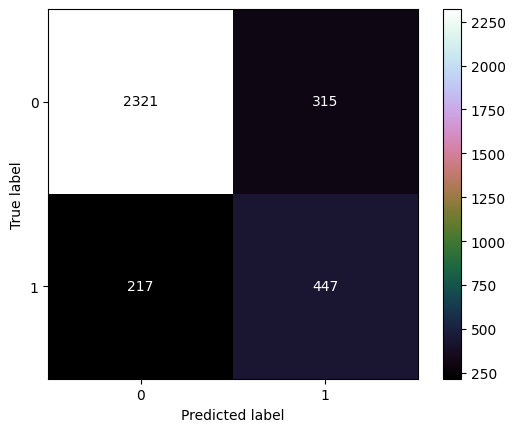

In [78]:
disp = ConfusionMatrixDisplay(confusion_matrix= matrix_absolute,
                              display_labels= best_model.classes_)
disp.plot(cmap= plt.cm.cubehelix);

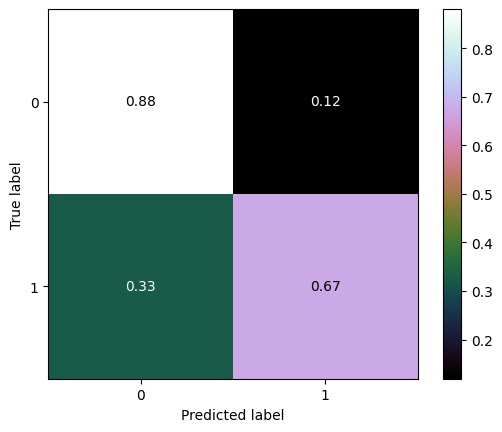

In [79]:
disp = ConfusionMatrixDisplay(confusion_matrix= matrix_percentage,
                              display_labels= best_model.classes_)
disp.plot(cmap= plt.cm.cubehelix);

### ROC AUC

In [57]:
roc_auc_score_xgb = roc_auc_score(y_test, yhat_xgb)

pred_prob_xgb = best_model.predict_proba(X_test)

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob_xgb[:, 1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

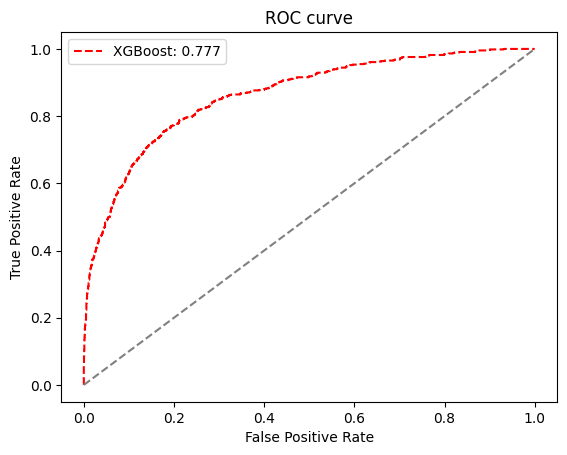

In [58]:
plt.plot(fpr1, tpr1, linestyle='--',color='red', label=f'XGBoost: {roc_auc_score_xgb:.3f}')
plt.plot(p_fpr, p_tpr, linestyle='--', color='gray')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show();

# Tradução de Negócio

## Qual é a atual taxa de rotatividade (churn) do Top Bank?

- Foi respondida na análise univariada da variável resposta.

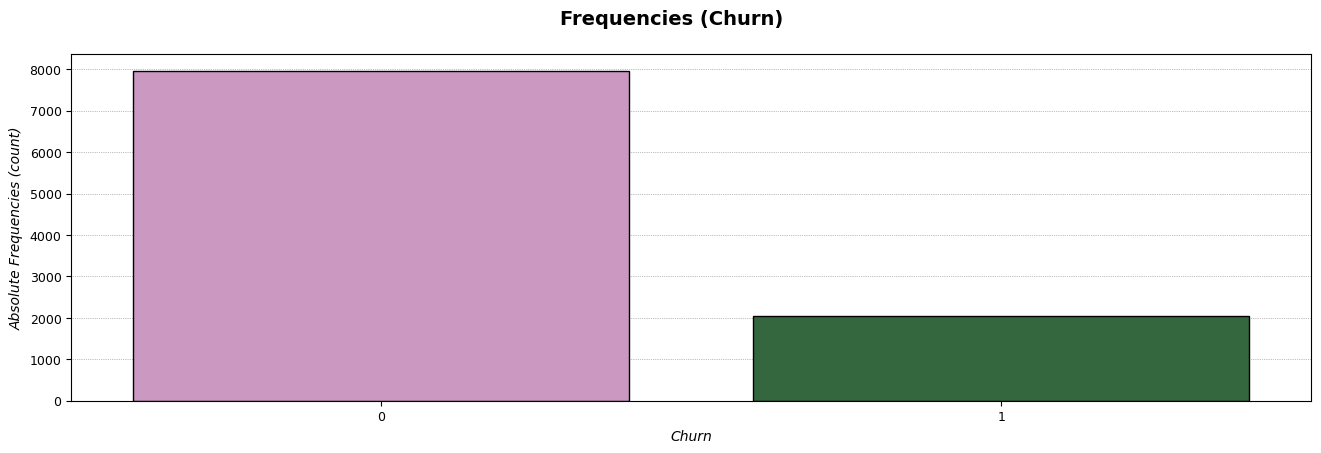

In [61]:
utils.plot_nominal_variables_distributions(target_var_df)

In [ ]:
percentage_no_churn = df8[['id_cliente', 'Churn']].loc[df8['Churn'] == 0].shape[0] / df8.shape[0] * 100
percentage_yes_churn = df8[['id_cliente', 'Churn']].loc[df8['Churn'] == 1].shape[0] / df8.shape[0] * 100
print(f'R: Clientes que irão dar Churn correspondem a {percentage_yes_churn:.2f}% da base de dados e clientes que não irão dar Churn correspondem a {percentage_no_churn:.2f}% da base de dados.')

## Qual é o desempenho do modelo na classificação de clientes como churns?

    R: O modelo desenvolvido possui um desempenho de 67% na identificação de clientes como churn.

## Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?

Considerando a base de dados atual, que temos 20,37% dos clientes como positivos para rotatividade e 79,63% negativos para rotatividade, e considerando o modelo XGBoost que acerta aproximadamente 67% dos clientes que são positivos para rotatividade, temos que:

In [68]:
recall = recall_score(y_test, yhat_xgb)

receita_não_churn = df.loc[df['Churn'] == 0]['salario_estimado'].sum()
receita_sim_churn = df.loc[df['Churn'] == 1]['salario_estimado'].sum() * recall

print(f'Considerando que a empresa vá converter todos os clientes que foram identificados pelo modelo desenvolvido como positivos para rotatividade, com um recall de {(recall * 100):.2f}% , a receita média anual será de US${(receita_não_churn + receita_sim_churn):.2f}')

Considerando que a empresa vá converter todos os clientes que foram identificados pelo modelo desenvolvido, como positivos para rotatividade, com um recall de 67.32% , a receita média anual será de US$933356055.48
